# Test of a basic model on solvability

This notebook is aimed at playing around with a basic model that provides solvability features to be trained on a machine learning model to flag risky cases of overdraft.

## Import

In [40]:
import numpy as np
import pandas as pd
import datetime
import radar

%matplotlib inline
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from IPython.core.debugger import set_trace # add set_trace() where you need a breakpoint

## Create datasets simulating random bank transactions per customer

Each customer has a unique identifier, in the form _AB12345_
There are 3 datasets to generate:

* The dataset __inflows__ (r. __outflows__) returns all the the cash inflows (r. outflows) with their corresponding date, sorted per customer
* The dataset __balance__ returns the balance of each customer, per month

| Customer Id |  Amount  |        Date        |
|-------------|----------|--------------------|
|   AB12345   |   20.34  |  2017-07-05T11:21  |

| Customer Id |  Balance   |        Date        |
|-------------|------------|--------------------|
|   AB12345   |   5036.67  |  2017-07-01        |

### Dataset balance

Initialize columns of __inflows__ and __outflows__

In [2]:
outflows = pd.DataFrame(columns=['Customer Id', 'Amount', 'Date'], dtype=float)

A couple of functions first

In [41]:
def generate_customers(list_countries:list=['BE','FR','GB','LU'], nb_of_customers:int=100):
    customers = []
    for _ in range(0, nb_of_customers):
        country = list_countries[np.random.randint(0, len(list_countries))]
        cust_id = np.random.randint(00000, 99999)
        customers.append('{0}{1:0}'.format(country, cust_id))
    return customers

def populate_df(df:pd.DataFrame, customers:list, nb_of_transactions_max:int=0, nb_of_transactions_min:int=0, trans_lower:int=0, trans_upper:int=20000, year_lower:int=2015, year_upper:int=2016, month_lower:int=1, month_upper:int=12, day_lower:int=1, day_upper:int=31, list_of_months:list = None, fixedAmount:bool=False):
    for customer in customers:
        #print('Customer: {0}'.format(customer))
        for _ in range(0, np.random.randint(nb_of_transactions_min, nb_of_transactions_max+1)):
            amount = np.random.randint(trans_lower*100, trans_upper*100)/100  # to get a real sense of financial transaction, /100
            year = np.random.randint(year_lower, year_upper)
            if list_of_months is None:
                list_of_months = np.random.randint(month_lower, month_upper, size=month_upper-month_lower)
            for month in list_of_months:
                if month == 12:
                    day = np.random.randint(day_lower, (datetime.datetime(year+1, (month+1)%12, 1) - datetime.datetime(year, month, 1)).days)
                else:
                    day = np.random.randint(day_lower, min(day_upper, (datetime.datetime(year, month+1, 1) - datetime.datetime(year, month, 1)).days))   # to make sure to have a valid day for the present month
                date = datetime.datetime(year, month, day)
                if not(fixedAmount):
                    amount = np.random.randint(trans_lower*100, trans_upper*100)/100  # to get a real sense of financial transaction, /100
                df.loc[len(df)] = pd.Series({'Customer Id':customer, 'Amount':amount, 'Date':date})
                #print('Customer - Transaction - Amount: {0} - {1} - {2}'.format(customer, _, amount))

Generate list of customers

In [42]:
customers = generate_customers(nb_of_customers=5)

Generate __inflows__

In [43]:
def generate_inflows():
    inflows = pd.DataFrame(columns=['Customer Id', 'Amount', 'Date'], dtype=float)
    # populate random reimbursements
    populate_df(inflows, customers, nb_of_transactions_min=0, nb_of_transactions_max=3, trans_lower=10, trans_upper=300)
    # populate monthly salaries
    populate_df(inflows, customers, nb_of_transactions_min=1, nb_of_transactions_max=1, trans_lower=2000, trans_upper=5000, day_lower=25, day_upper=30, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], fixedAmount=True)
    return inflows

Group __inflows__ by _Customer Id_

In [ ]:
inflows_grouped_by_id = inflows.sort_values('Customer Id')

Generate __outflows__

In [44]:
def generate_outflows():
    outflows = pd.DataFrame(columns=['Customer Id', 'Amount', 'Date'], dtype=float)
    # populate random small expenses
    populate_df(outflows, customers, nb_of_transactions_min=1, nb_of_transactions_max=10, trans_lower=1, trans_upper=30, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    # populate random medium expenses
    populate_df(outflows, customers, nb_of_transactions_min=1, nb_of_transactions_max=2, trans_lower=30, trans_upper=100, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    # populate random big expenses
    populate_df(outflows, customers, nb_of_transactions_min=1, nb_of_transactions_max=1, trans_lower=200, trans_upper=600, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    # populate random outstanding expenses
    populate_df(outflows, customers, nb_of_transactions_min=1, nb_of_transactions_max=1, trans_lower=600, trans_upper=3000)
    # populate monthly rent
    populate_df(outflows, customers, nb_of_transactions_min=1, nb_of_transactions_max=1, trans_lower=500, trans_upper=1500, day_lower=1, day_upper=5, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], fixedAmount=True)
    # populate monthly car
    populate_df(outflows, customers, nb_of_transactions_max=1, trans_lower=200, trans_upper=800, day_lower=23, day_upper=31, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    # populate monthly electricity
    populate_df(outflows, customers, nb_of_transactions_max=1, trans_lower=20, trans_upper=80, day_lower=1, day_upper=5, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    # populate weekly grocery shopping
    populate_df(outflows, customers, nb_of_transactions_min=4, nb_of_transactions_max=5, trans_lower=20, trans_upper=80, day_lower=1, day_upper=31, list_of_months=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])
    return outflows

Populating __balance__ given __inflows__ and __outflows__ per Customer Id

In [45]:
inflows = generate_inflows()
inflows.index = inflows['Date']
outflows = generate_outflows()
outflows.index = outflows['Date']
balances = (inflows.groupby(by='Customer Id').resample('M').sum().fillna(0)-outflows.groupby(by='Customer Id').resample('M').sum().fillna(0)).fillna(0).groupby(by='Customer Id').cumsum()

In [46]:
balances = balances.pivot_table(index='Customer Id', columns='Date', values='Amount')

## Plotting monthly __balance__

import

In [47]:
balances

Date,2015-01-31 00:00:00,2015-02-28 00:00:00,2015-03-31 00:00:00,2015-04-30 00:00:00,2015-05-31 00:00:00,2015-06-30 00:00:00,2015-07-31 00:00:00,2015-08-31 00:00:00,2015-09-30 00:00:00,2015-10-31 00:00:00,2015-11-30 00:00:00,2015-12-31 00:00:00
Customer Id,,,,,,,,,,,,
BE91048,-5630.53,-8440.90,-12793.39,-13226.42,-15051.49,-15991.65,-16546.12,-17073.02,-18746.42,-19128.09,-24028.86,-24341.50
FR81531,-4211.06,-3296.53,-5578.17,-2809.82,-2438.80,-312.74,574.57,2972.09,4198.28,6510.58,6052.67,8215.83
FR93326,-3053.55,-2734.91,-4355.08,-2049.30,-2148.11,301.03,365.97,2022.33,2306.45,4444.30,3537.15,5630.16
GB97728,-1191.83,2581.21,1658.37,5137.02,6103.55,9200.44,12109.54,15141.76,16137.61,19068.41,20429.22,23438.44
LU27298,-3900.33,-679.20,-1985.59,988.68,2817.75,4890.16,7119.91,9668.17,10862.33,12713.98,10378.74,12671.70


In [48]:
from scipy.special import binom

def Bernstein(n, k):
    coeff = binom(n, k)
    def _bpoly(x):
        return coeff * x ** k * (1 - x) ** (n - k)
    return _bpoly

def Bezier(points, num=200):
    N = len(points)
    t = np.linspace(0, 1, num=num)
    curve = np.zeros((num, 2))
    for ii in range(N):
        curve += np.outer(Bernstein(N - 1, ii)(t), points[ii])
    return curve

Amount: -24341.499999999993 - Slope: -1576.8890303872781
Amount: 8215.829999999998 - Slope: 1453.4365974306586
Amount: 5630.160000000005 - Slope: 1258.3182843423442
Amount: 23438.440000000006 - Slope: 2528.1602592555287
Amount: 12671.700000000004 - Slope: 994.4740566978712


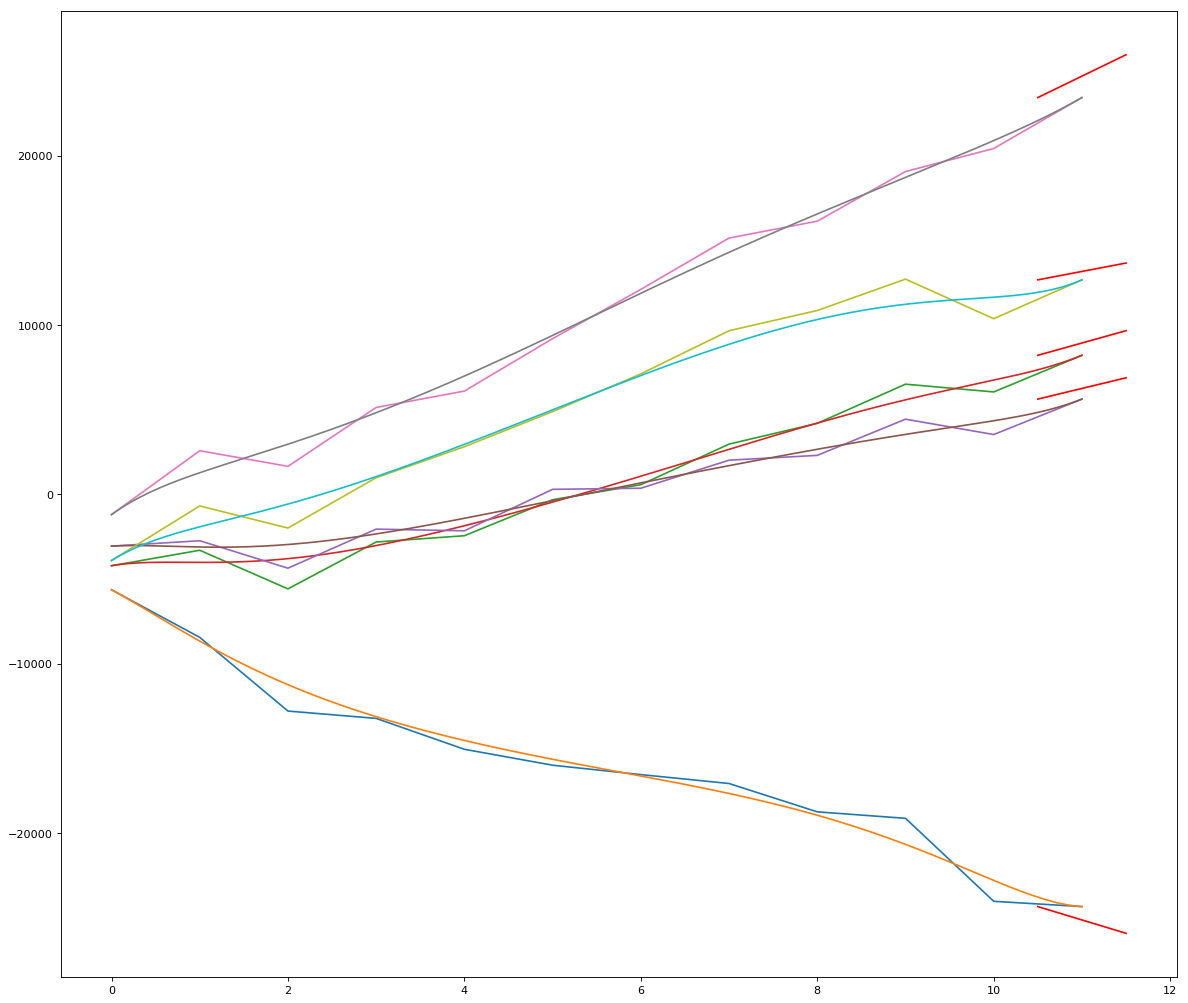

In [49]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
x = np.linspace(0, 11, num=12, endpoint=True)
x_ext = np.linspace(10.5, 11.5, num=2, endpoint=True)
x_new = np.linspace(0, 11, num=120, endpoint=True)
#sns.palplot(sns.color_palette("BuGn_r"))
for _ in range(0, len(balances)):
    #ax = sns.tsplot(data=balances.iloc[_])
    y = balances.iloc[_]
    #sp = interp1d(x, y, kind='cubic')
    #plt.plot(x, y, '-', x_new, sp(x_new))
    x_new, y_new = Bezier(list(zip(x, y))).T
    slope = (y_new[-1] - y_new[-20])/(x_new[-1] - x_new[-20])
    y_ext = np.array([y_new[-1], y_new[-1]+slope])
    plt.plot(x, y, '-', x_new, y_new, x_ext, y_ext, 'r')
    print('Amount: {0} - Slope: {1}'.format(y_new[-1], slope))
    #for i in range(len(y)):
    #    print('Distance between balance and Bezier curve: {0}'.format(y_new[i]-y[i]))

Amount: 12671.700000000004 - Slope: 5743.32985931992
Amount: 12671.700000000004 - Slope: 5788.753974692963
Amount: 12671.700000000004 - Slope: 6262.809457934717
Amount: 12671.700000000004 - Slope: 5400.497371845472
Amount: 12671.700000000004 - Slope: 8158.47218918572


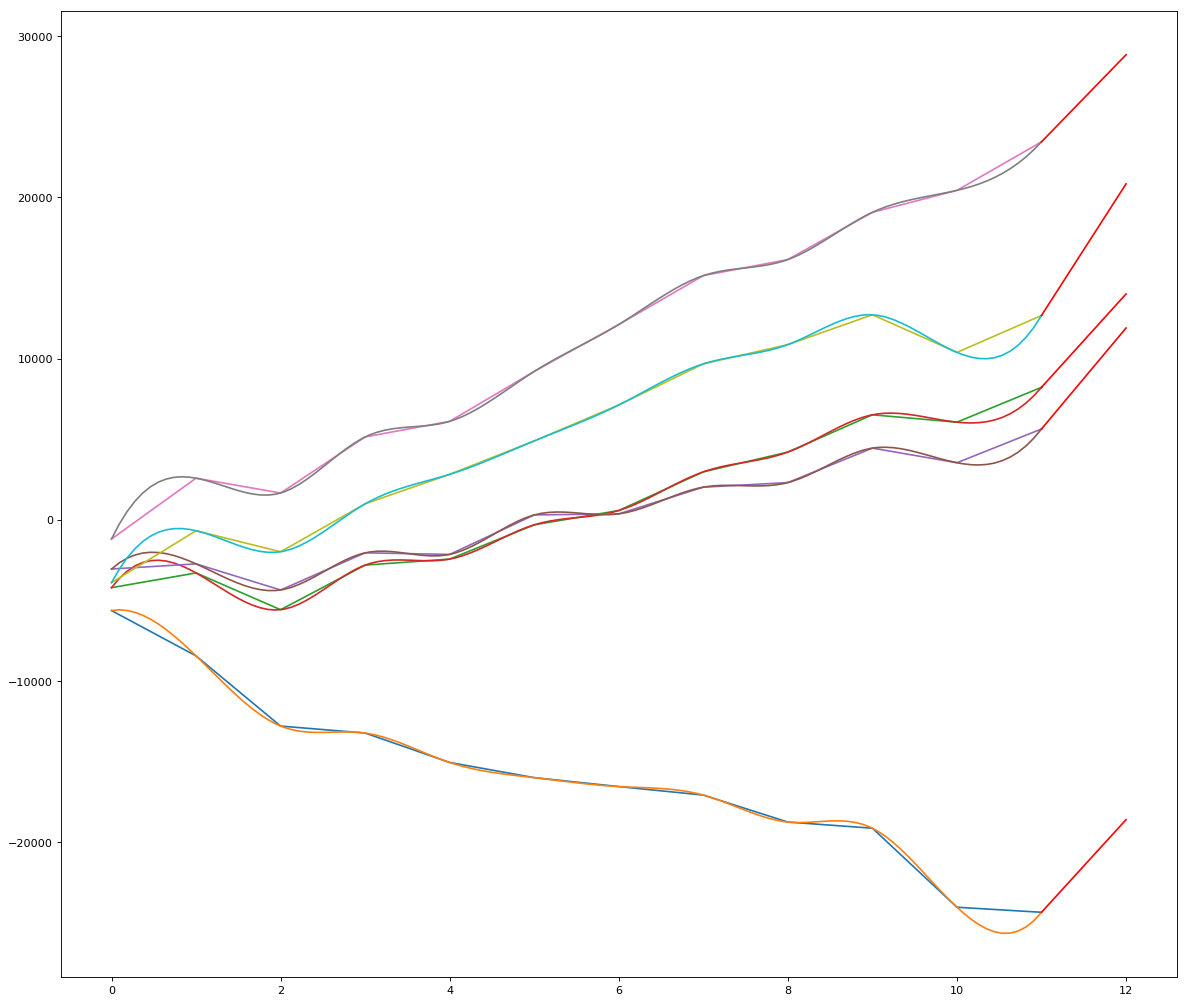

In [50]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
x = np.linspace(0, 11, num=12, endpoint=True)
x_ext = np.linspace(11, 12, num=2, endpoint=True)
x_new = np.linspace(0, 11, num=120, endpoint=True)
#sns.palplot(sns.color_palette("BuGn_r"))
for _ in range(0, len(balances)):
    #ax = sns.tsplot(data=balances.iloc[_])
    y = balances.iloc[_]
    sp = interp1d(x, y, kind='cubic')
    slope = (sp(x_new)[-2] - sp(x_new)[-1])/(x_new[-2] - x_new[-1])
    y_ext = np.array([sp(x_new)[-1], sp(x_new)[-1]+slope])
    plt.plot(x, y, '-', x_new, sp(x_new), x_ext, y_ext, 'r')
    print('Amount: {0} - Slope: {1}'.format(y_new[-1], slope))

## Plotting __outflows__

In [66]:
#outflows
#outflows.groupby(by='Customer Id').resample('D').sum().fillna(0)
#outflows.index = outflows['Customer Id']
outflows = generate_outflows()
outflows.index = outflows['Date']

#outflows.groupby(by='Customer Id').resample('D').fillna(0)
#outflows.groupby(by='Customer Id').resample('D')
#outflows

#outflows = (outflows.groupby(by='Customer Id').resample('D').sum().fillna(0)).fillna(0).groupby(by='Customer Id').cumsum()
outflows = outflows.groupby(by='Customer Id').resample('D').sum().fillna(0)
#outflows = outflows.groupby(by='Customer Id')

In [67]:
outflows = outflows.pivot_table(index='Customer Id', columns='Date', values='Amount').fillna(0)
outflows

Date,2015-01-01 00:00:00,2015-01-02 00:00:00,2015-01-03 00:00:00,2015-01-04 00:00:00,2015-01-05 00:00:00,2015-01-06 00:00:00,2015-01-07 00:00:00,2015-01-08 00:00:00,2015-01-09 00:00:00,2015-01-10 00:00:00,...,2015-12-21 00:00:00,2015-12-22 00:00:00,2015-12-23 00:00:00,2015-12-24 00:00:00,2015-12-25 00:00:00,2015-12-26 00:00:00,2015-12-27 00:00:00,2015-12-28 00:00:00,2015-12-29 00:00:00,2015-12-30 00:00:00
Customer Id,,,,,,,,,,,,,,,,,,,,,
BE91048,75.99,1302.42,19.61,0.00,0.00,0.00,0.00,0.0,0.00,0.0,...,22.79,0.00,630.12,0.0,13.15,0.0,0.00,0.00,0.0,133.12
FR81531,1023.62,0.00,0.00,0.00,0.00,0.00,2106.92,0.0,90.30,0.0,...,30.95,0.00,0.00,0.0,81.45,0.0,0.00,1377.45,0.0,0.00
FR93326,11.79,0.00,1174.40,0.00,141.23,7.81,0.00,0.0,6.56,0.0,...,0.00,0.00,0.00,0.0,0.00,0.0,0.00,51.19,0.0,0.00
GB97728,0.00,25.94,63.02,906.25,17.76,0.00,4.20,0.0,0.00,0.0,...,0.00,18.78,254.15,725.4,0.00,0.0,96.65,0.00,0.0,0.00
LU27298,1151.08,454.55,0.00,54.79,0.00,32.08,0.00,0.0,0.00,0.0,...,0.00,0.00,86.17,0.0,0.00,0.0,0.00,0.00,0.0,59.02


In [371]:
outflows.shape[1]

364

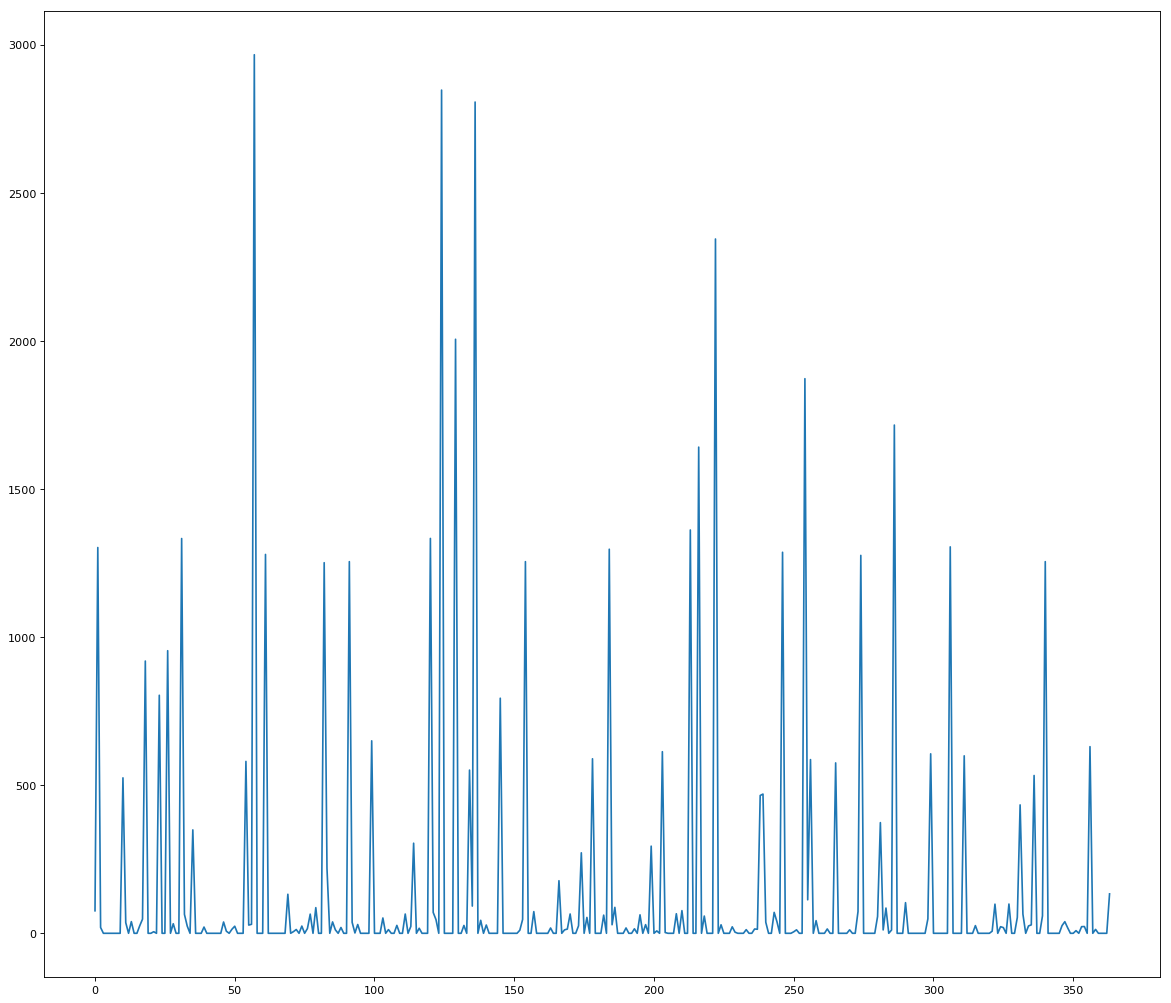

In [68]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
nb_of_days = outflows.shape[1]
x = np.linspace(0, nb_of_days-1, num=nb_of_days, endpoint=True)
#for _ in range(0, len(outflows)):
for _ in range(0, 1):
    y = outflows.iloc[_]
    plt.plot(x, y)

/Users/bertranddelvaux/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning:

Casting complex values to real discards the imaginary part



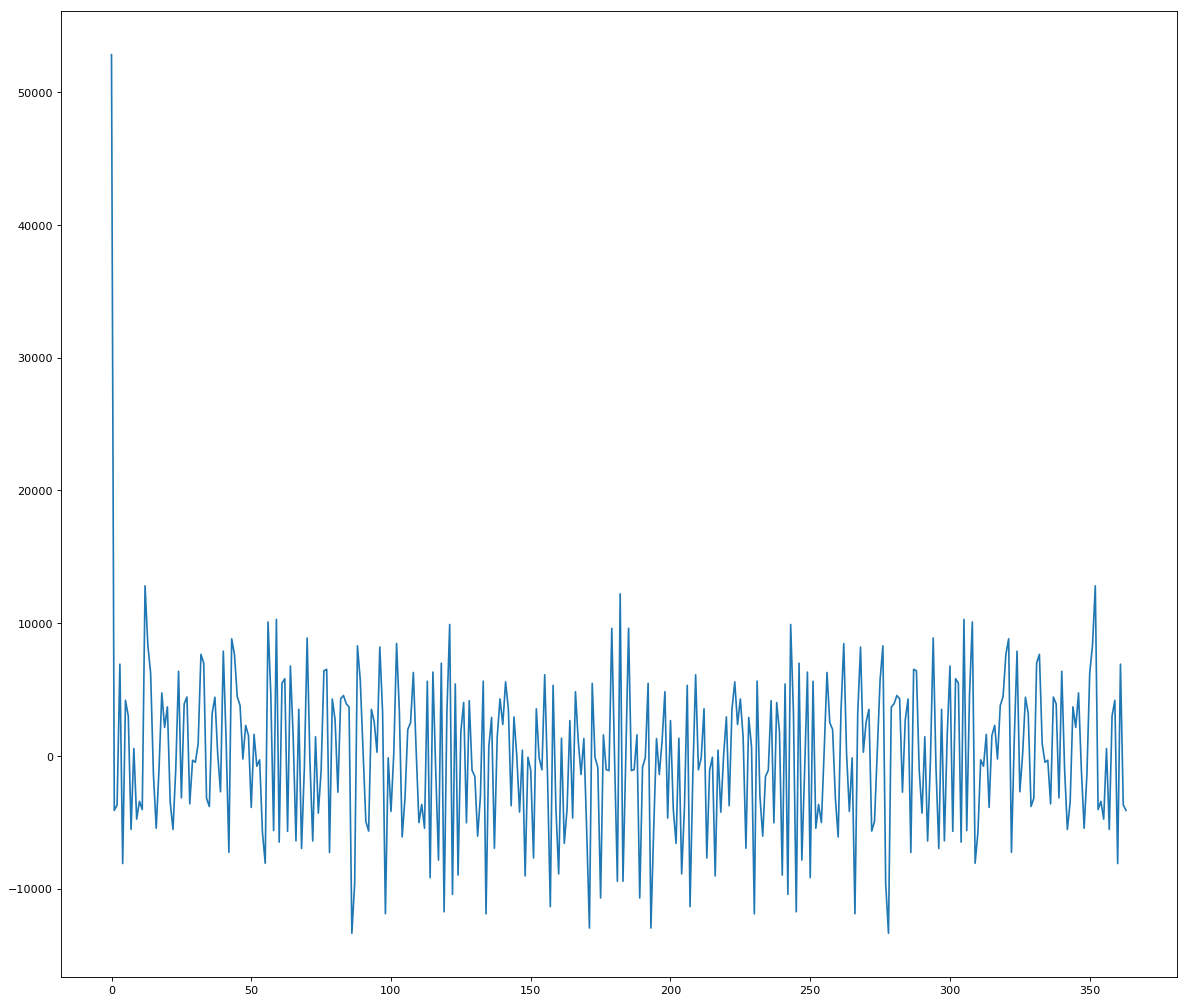

In [69]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
nb_of_days = outflows.shape[1]
#x = np.linspace(0, nb_of_days-1, num=nb_of_days, endpoint=True)
#for _ in range(0, len(outflows)):
for _ in range(0, 1):
    y = outflows.iloc[_]
    yf = np.fft.fft(y)
    plt.plot(yf)

## Plotting __inflows__

In [83]:
inflows = generate_inflows()
inflows.index = inflows['Date']

inflows = inflows.groupby(by='Customer Id').resample('D').sum().fillna(0)

In [84]:
inflows = inflows.pivot_table(index='Customer Id', columns='Date', values='Amount').fillna(0)
inflows

Date,2015-01-26 00:00:00,2015-01-27 00:00:00,2015-01-28 00:00:00,2015-01-29 00:00:00,2015-01-30 00:00:00,2015-01-31 00:00:00,2015-02-01 00:00:00,2015-02-02 00:00:00,2015-02-03 00:00:00,2015-02-04 00:00:00,...,2015-12-21 00:00:00,2015-12-22 00:00:00,2015-12-23 00:00:00,2015-12-24 00:00:00,2015-12-25 00:00:00,2015-12-26 00:00:00,2015-12-27 00:00:00,2015-12-28 00:00:00,2015-12-29 00:00:00,2015-12-30 00:00:00
Customer Id,,,,,,,,,,,,,,,,,,,,,
BE91048,0.00,0.00,3139.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,3139.75,0.00,0.00
FR81531,0.00,3251.46,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3251.46,0.0,0.0,0.00,0.00,0.00
FR93326,0.00,0.00,0.00,3133.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,3133.10
GB97728,4979.05,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,4979.05,0.00
LU27298,0.00,0.00,2123.16,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.00,2123.16


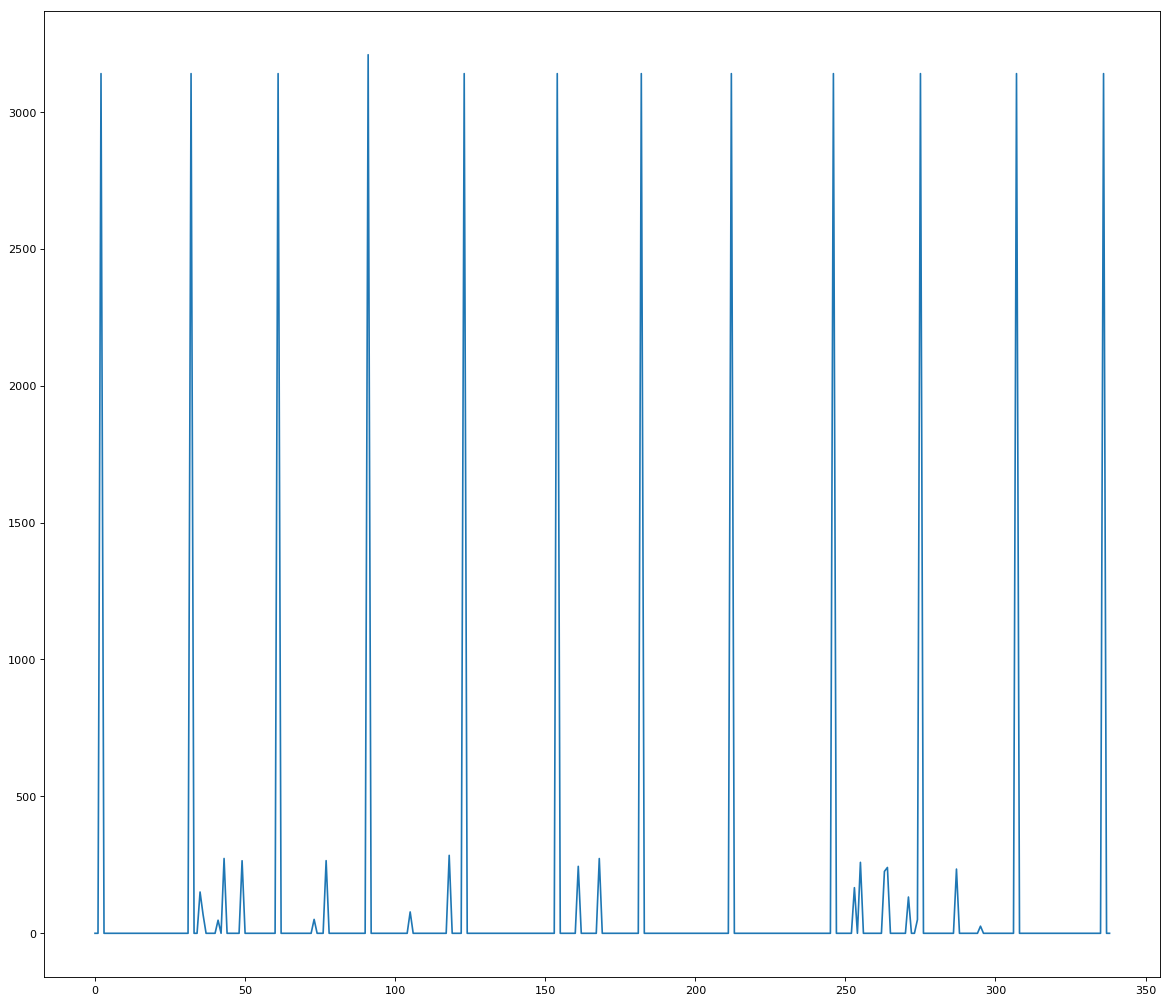

In [85]:
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
nb_of_days = inflows.shape[1]
x = np.linspace(0, nb_of_days-1, num=nb_of_days, endpoint=True)
#for _ in range(0, len(outflows)):
for _ in range(0, 1):
    y = inflows.iloc[_]
    plt.plot(x, y)

In [73]:
nb_of_days = inflows.shape[1]
t = np.linspace(0, (nb_of_days-1)/2, num=nb_of_days/2, endpoint=True)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
for _ in range(0, 1):
    y = inflows.iloc[_]
    yf = scipy.fftpack.fft(y)
    xFFT = abs(yf)/len(y)
    xDFT_psd = abs(yf**2)
    plt.plot(xFFT, t)

/Users/bertranddelvaux/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning:

object of type <class 'float'> cannot be safely interpreted as an integer.



NameError: name 'scipy' is not defined

/Users/bertranddelvaux/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  del sys.path[0]


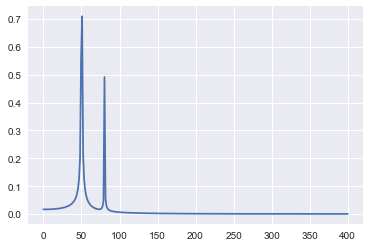

In [416]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = 600
# sample spacing
T = 1.0 / 800.0
x = np.linspace(0.0, N*T, N)
y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N/2)

fig, ax = plt.subplots()
ax.plot(xf, 2.0/N * np.abs(yf[:N//2]))
plt.show()

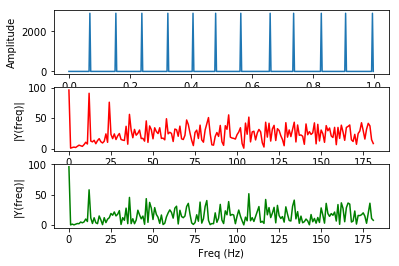

array([ 96.02043956,   0.87632803,   1.89119976,   2.59205857,
         1.9573395 ,   3.81464216,   5.7623225 ,   4.88309109,
         3.83037719,   6.71588462,  10.52618516,   7.66677018,
        90.6800361 ,  12.48911963,  11.17289229,  13.74183439,
         8.15294183,  13.17233854,  16.40311898,  11.35674739,
         9.33496503,  12.23806296,  24.19969487,  10.40698346,
        76.05942113,  23.50429953,  16.46079727,  24.17655529,
        15.00303948,  21.00547498,  24.782764  ,  15.09404264,
        14.02178253,  13.43555893,  36.64612186,   7.32728823,
        56.16137611,  30.46585407,  17.89758731,  31.50914914,
        22.05049394,  25.23257364,  30.51719788,  16.60232705,
        16.93926784,  12.33533793,  45.45932162,  10.30418268,
        37.23292308,  31.10320234,  16.14980615,  34.22389382,
        27.95762491,  24.73115422,  34.25992894,  16.80771628,
        17.31093139,  14.49614908,  49.01674989,  24.36197673,
        26.8275916 ,  24.96138767,  11.76310542,  32.14

In [82]:
import matplotlib.pyplot as plt
import numpy as np

y = inflows.iloc[0]
Fs = len(y);  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(0,1,Ts) # time vector

ff = 5;   # frequency of the signal
#y = np.sin(2*np.pi*ff*t)
#x = np.linspace(-15, 15, 30)
#data = np.sinc(x)
a = [1]
data = np.pad(a, (0, int(Fs/ff)-1), 'constant')
#y = np.pad(data, (0, 120), 'constant')
#y = np.tile(data, ff)

n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(int(n/2))] # one side frequency range

Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(int(n/2))]

fig, ax = plt.subplots(3, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Amplitude')
#ax[1].plot(abs(Y),'r')
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
ax[2].plot(frq,abs(np.real(Y)),'g') # plotting the spectrum
ax[2].set_xlabel('Freq (Hz)')
ax[2].set_ylabel('|Y(freq)|')

plt.show()
#plot_url = py.plot_mpl(fig, filename='mpl-basic-fft')
abs(Y)

In [36]:
    def cos_profile(x: np.ndarray, y: np.ndarray):
        # pre-processing
        eps = np.finfo(float).eps
        x = x.astype('float64')
        y = y.astype('float64')
        n = len(x)
        m = len(y)

        # dot products
        dot_product = np.correlate(x, y, 'valid')

        # dot products x by himself, by "slices" of length m
        x2_cum_sum = np.pad(np.cumsum(x ** 2), (1, 0), 'constant')
        x_dot_product = x2_cum_sum[m:n + 1] - x2_cum_sum[0:n + 1 - m]

        # correction to avoid division by zero
        x_dot_product[x_dot_product == 0] = eps

        # norm
        y_norm = np.linalg.norm(y)

        # computing the distances
        cosinus = dot_product / (np.sqrt(x_dot_product) * y_norm)

        return cosinus

In [76]:
cos_profile(inflows.iloc[0][0:30], inflows.iloc[0])

ValueError: operands could not be broadcast together with shapes (335,) (0,) 

In [95]:
inflows.iloc[0].to_csv('data.csv')